In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [2]:
import gym
env = gym.make("CartPole-v1")
obs = env.reset()
obs
####각각 카트 수평위치, 카트 속도, 막대 각도, 막대 각속도

array([-0.0461906 , -0.02063419,  0.04314876,  0.00705948], dtype=float32)

In [3]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

In [4]:
# plot_environment(env)
# plt.show()

In [5]:
img = env.render(mode="rgb_array")
img.shape

C:\Users\hjhhi\anaconda3\envs\python3.6.8\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 스레드 모드가 설정된 후에는 바꿀 수 없습니다
  warnings.warn(str(err))


(400, 600, 3)

In [6]:
env.action_space

Discrete(2)

In [7]:
action=1
obs, reward, done, info = env.step(action)
obs

array([ 0.00559216,  0.17431584,  0.04849188, -0.30695853], dtype=float32)

In [8]:
reward

1.0

In [9]:
done

False

In [10]:
info

{}

In [4]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1
totals=[]
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [12]:
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

41.214 8.574858832657247 24.0 68.0


In [13]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [5]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [15]:
plot_animation(frames)

In [16]:
n_inputs = 4
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

# 정책 그래디언트 

In [6]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 2]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
###### tf,reduce_mean은 텐서의 특정 축 값을 전부 더해서 len(원소 수)로 나눠줌 없을 시 모든 원소 합함
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [7]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:   
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [8]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [20]:
discount_rewards([10, 0, -50], 0.8)

array([-22, -40, -50])

In [21]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], 0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [22]:
n_iteration=150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [23]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [24]:
for iteration in range(n_iteration):
    all_rewards, all_grads = play_multiple_episodes(
    env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    
    all_mean_grads=[]
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
            for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

In [42]:
np.array(all_rewards).sum()

2000.0

In [54]:
len(model.trainable_variables)

4

In [60]:
all_mean_grads

[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
 array([[-1.5531044e-03,  2.1297160e-04,  8.0465317e-05,  2.4752435e-03,
         -2.4279431e-04],
        [ 2.2489647e-03, -8.2624890e-04, -8.7316614e-03, -1.0000690e-02,
          4.0723683e-04],
        [-1.6719729e-04,  1.6218566e-04,  7.2579016e-04,  5.5940379e-04,
         -3.4279226e-05],
        [-1.2299070e-03,  7.0141745e-04,  4.0113018e-03,  4.1992427e-03,
         -2.1142617e-04]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-0.00202173,  0.00198197,  0.00947445,  0.00987856, -0.000351  ],
       dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 0.00053823],
        [-0.00275461],
        [-0.00134186],
        [-0.00223923],
        [ 0.00329582]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.00556229], dtype=float32)>]

In [25]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

In [62]:
np.array(all_rewards[9]).sum()

200.0

# Q 가치

In [10]:
transition_probabilities = [[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
                           [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
                           [None, [0.8, 0.1, 0.1], None]]
                        
rewards = [[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
    
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [28]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [12]:
gamma = 0.9

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
            for sp in range(3)])

In [13]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [14]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)

In [15]:
for state, actions in enumerate(possible_actions):
    print(state,actions)

0 [0, 1, 2]
1 [0, 2]
2 [1]


In [16]:
np.sum([transition_probabilities[0][1][sp] * (rewards[0][1][sp] + gamma * np.max(Q_prev[sp]))
            for sp in range(3)])

17.02702702452192

### 할인계수 0.95

In [64]:
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해서

In [65]:
gamma = 0.95  # 할인 계수

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])
            
history1 = np.array(history1)

In [66]:
Q_values

array([[21.73304188, 20.63807938, 16.70138772],
       [ 0.95462106,        -inf,  1.01361207],
       [       -inf, 53.70728682,        -inf]])

In [67]:
np.argmax(Q_values, axis=1)

array([0, 2, 1], dtype=int64)

# 시간차 학습, Q러닝

In [22]:
def step(state, action):
    probas = transition_probabilities[state][action]
######random.choice -> 첫번쨰 인자를 list로 줄 시 원소의 값을 균등분포로 출력 p매개변수에 값을 넣어 각각의 확률 지정가능
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
##### next_state와 reward는 각각 s -> s'에서 s의 전이확률에 맞춘 s'와 그로 향할떄의 보상을 반환한다
    return next_state, reward

In [23]:
def exploration_policy(state):
###### 얘는 균등분포이므로 그냥 가능한 선택지에서 랜덤하게 뽑는다
    return np.random.choice(possible_actions[state])

In [51]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [52]:
Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [53]:
alpha0 = 0.05
decay = 0.005
gamma = 0.90
state=0
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
##### 이전Q가치를 감소시키는 역활
    Q_values[state, action] *= 1 - alpha
##### Q가치 함수에 alpha적용
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state
    
history2 = np.array(history2)

In [54]:
Q_values

array([[17.8808603 , 15.40440483, 12.29549146],
       [ 0.        ,        -inf, -9.38073531],
       [       -inf, 48.36326377,        -inf]])

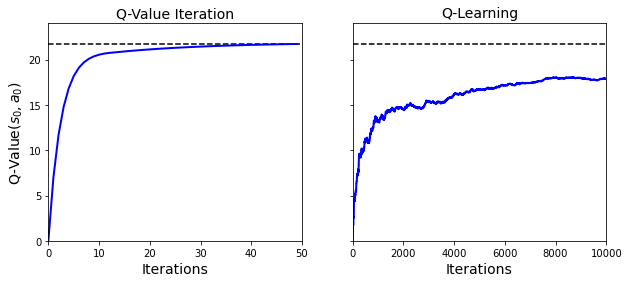

In [73]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    
### 그래프를 Q_가치반복의 마지막 a0 -> a0를 목표로 잡았는데 이게 목표로 적당한건가?

# 탐험 정책 